In [28]:
# clip install instructions, the paper, code examples etc are here: https://github.com/openai/CLIP 

In [1]:
import os 

import torch
import clip
from PIL import Image
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print("Everythings fine")

Everythings fine


# Load a pretrained model (here CLIP)

In [2]:
device = "mps" # set your GPU backend here. MPS is for Mac M1 Chips
images = "./Images/"

model, preprocess = clip.load("ViT-B/32", device=device)

-------

# Text Embeddings

In [3]:
# the basic workflow to get text embeddings from the clip model

# you can pass a list, no need to encode each sentence individually
database = [
    'a labrador',
    'a dalmatian',
    'a sparrow',
    'two dogs jumping around',
    'a car'
]

# text must be converted to clip token first
tokens = clip.tokenize(database).to(device)

# don't forget to use no_grad, otherwise you'll calculate gradients
with torch.no_grad():
    # get the embeddings
    vector_db = model.encode_text(tokens)
vector_db.shape 

torch.Size([5, 512])

In [4]:
# same here as function
def get_text_embedding(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

# usually, you store normalized embeddings to calculate the cosine similarity later
def get_normed_text_embedding(texts):
    embed = get_text_embedding(texts)
    embed /= embed.norm(dim=-1, keepdim=True)
    return embed

## Text similarity

In [5]:

database = [
    'a labrador',
    'a dalmatian',
    'a sparrow',
    'two dogs jumping around',
    'a car'
]
vector_db = get_normed_text_embedding(database)

In [29]:
# play with different targets here!
target_text = "a truck"
target = get_normed_text_embedding(target_text)

### Cosine Similarity is now reduced to dot product

In [37]:
similarity = target @ vector_db.T
# convert to (pseudo probabilities)
probs = similarity.softmax(dim=-1)

# the probs. usually, they are very evenly distributed - the curse of dimensionality!
# for more distinct probabilities, you can simply use temperature scaling
print(probs[0])


print("And temperature scaled:")
# temperature scaling with tau = 0.01 (* 100) shifts it to a point distribution. Confident models may be useful sometimes.
similarity = target @ vector_db.T * 100
probs = similarity.softmax(dim=-1)
print(probs[0])

tensor([0.1586, 0.1549, 0.1613, 0.1665, 0.1860, 0.1732], device='mps:0',
       dtype=torch.float16)
And temperature scaled:
tensor([1.1921e-07, 0.0000e+00, 5.9605e-07, 1.4722e-05, 9.9902e-01, 7.5531e-04],
       device='mps:0', dtype=torch.float16)


In [38]:
_, ind = probs[0].topk(1) # find the highest value and it's position in the database
print(f"Most similar to '{target_text}' is:\n'{database[ind]}'")

Most similar to 'a truck' is:
'a car'


----------

# Image Classification

Here you can find a short code sample to create a text-based vector DB and how you can use the power of multimodal pretrained models, to perform a similarity search with images to texts. For more tips read the original paper (linked on top of this notebook) or feel free to ask me!

In [39]:
# some sample images
snow = os.path.join(images, "snow.png")
mirrored = os.path.join(images, "mirrored.png")
expressionist = os.path.join(images, "expressionist.png")
joyful = os.path.join(images, "joyful.png")

images = [snow,
         mirrored,
         expressionist,
         joyful]

TypeError: expected str, bytes or os.PathLike object, not list

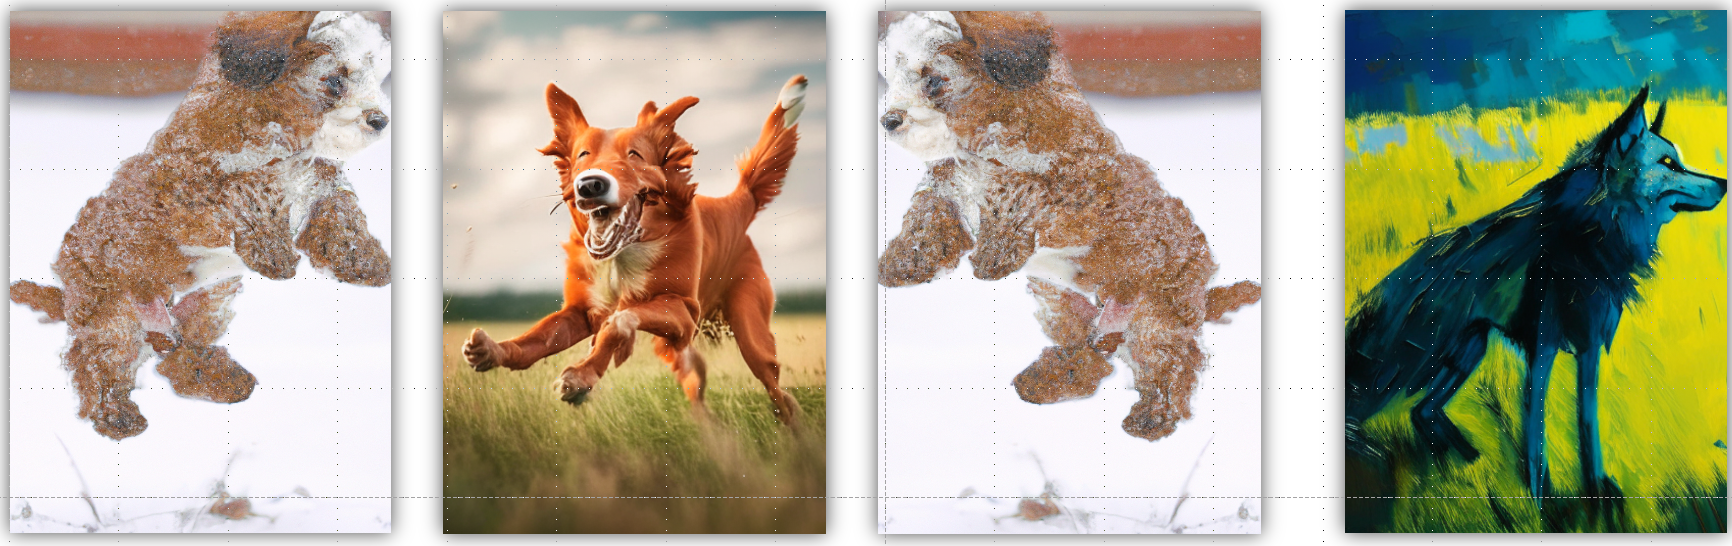

In [40]:
# get the image embeddings. Uses the clip specific preprocessor
def get_image_embedding(img):
    img = preprocess(Image.open(img)).unsqueeze(0).to(device)
    return model.encode_image(img)
def get_normed_image_embedding(img):
    embed = get_image_embedding(img)
    embed /= embed.norm(dim=-1, keepdim=True)
    return embed

In [41]:
# create database
image_database = [get_normed_image_embedding(img) for img in images]

In [44]:
# and a text database. These are the "labels" for a classification task
database = [
    'a labrador',
    'a german shephard',
    'a sparrow',
    'an elephant',
    'a car',
    'a wolf'
]
vector_db = get_normed_text_embedding(database)
print(database)


['a labrador', 'a german shephard', 'a sparrow', 'an elephant', 'a car', 'a wolf']


Most similar text from db: a german shephard




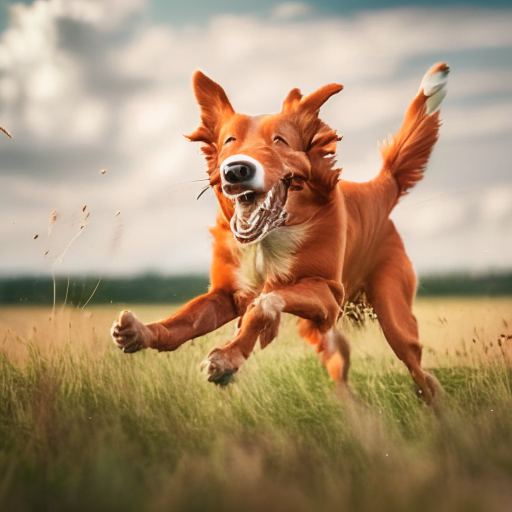

In [45]:
# seclect one of the images
num_image = 3

# get pre-calculated embeddings from our image db
image_features = image_database[num_image]

# calc the similarity in one step
similarity = (100.0 * image_features @ vector_db.T).softmax(dim=-1)
# find best match
_, indice = similarity.topk(1)
print(f"Most similar text from db: {database[indice]}\n\n")

# display it for clarity
image = Image.open(images[num_image]).convert('RGB')
display(image)

